In [36]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import confusion_matrix, f1_score
import torch
from torch import nn, optim
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt

# 데이터 로드
data = pd.read_csv('BP_data.csv')
data

,Patient_Number,Blood_Pressure_Abnormality,Level_of_Hemoglobin,Genetic_Pedigree_Coefficient,Age,BMI,Sex,Pregnancy,Smoking,Physical_activity,salt_content_in_the_diet,alcohol_consumption_per_day,Level_of_Stress,Chronic_kidney_disease,Adrenal_and_thyroid_disorders
0,1,1,11.28,0.90,34,23,1,1.0,0,45961,48071,NaN,2,1,1
1,2,0,9.75,0.23,54,33,1,NaN,0,26106,25333,205.0,3,0,0
2,3,1,10.79,0.91,70,49,0,NaN,0,9995,29465,67.0,2,1,0
3,4,0,11.00,0.43,71,50,0,NaN,0,10635,7439,242.0,1,1,0
4,5,1,14.17,0.83,52,19,0,NaN,0,15619,49644,397.0,2,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,1996,1,10.14,0.02,69,26,1,NaN,1,26118,47568,144.0,3,1,0
1996,1997,1,11.77,1.00,24,45,1,1.0,1,2572,8063,NaN,3,1,1
1997,1998,1,16.91,0.22,18,42,0,NaN,0,14933,24753,NaN,2,1,1
1998,1999,0,11.15,0.72,46,45,1,NaN,1,18157,15275,253.0,3,0,1


In [20]:
# 데이터 확인
print("데이터 형태:", data.shape)
print("\n컬럼 정보:\n", data.columns)

# 결측치 확인
print("=== 결측치 현황 ===")
print(data.isnull().sum())

print("\n=== 레이블 분포 ===")
print(data['Blood_Pressure_Abnormality'].value_counts())

데이터 형태: (2000, 15)

컬럼 정보:
 Index(['Patient_Number', 'Blood_Pressure_Abnormality', 'Level_of_Hemoglobin',
       'Genetic_Pedigree_Coefficient', 'Age', 'BMI', 'Sex', 'Pregnancy',
       'Smoking', 'Physical_activity', 'salt_content_in_the_diet',
       'alcohol_consumption_per_day', 'Level_of_Stress',
       'Chronic_kidney_disease', 'Adrenal_and_thyroid_disorders'],
      dtype='object')
=== 결측치 현황 ===
Patient_Number                      0
Blood_Pressure_Abnormality          0
Level_of_Hemoglobin                 0
Genetic_Pedigree_Coefficient       92
Age                                 0
BMI                                 0
Sex                                 0
Pregnancy                        1558
Smoking                             0
Physical_activity                   0
salt_content_in_the_diet            0
alcohol_consumption_per_day       242
Level_of_Stress                     0
Chronic_kidney_disease              0
Adrenal_and_thyroid_disorders       0
dtype: int64

=== 레이블 분

In [21]:
# 환자 번호 제거
data = data.drop('Patient_Number', axis=1)

# 결측치 처리 ( 방법이 여러가지 있음 지피티에서 여러방법 알아보기 ) 
num_cols = data.select_dtypes(include=np.number).columns.tolist()
num_cols.remove('Blood_Pressure_Abnormality')  # 타겟 변수 제외
imputer = SimpleImputer(strategy='median')
data[num_cols] = imputer.fit_transform(data[num_cols])

In [22]:
# # 평균 대체
# data['col'] = data['col'].fillna(data['col'].mean())
# # KNN 대체
# from sklearn.impute import KNNImputer
# imputer = KNNImputer(n_neighbors=3)
# data[num_cols] = imputer.fit_transform(data[num_cols])
# # 다중 대체(MICE)
# from sklearn.experimental import enable_iterative_imputer
# from sklearn.impute import IterativeImputer
# imputer = IterativeImputer()
# data[num_cols] = imputer.fit_transform(data[num_cols])

In [23]:
# 범주형 변수 인코딩
le = LabelEncoder()
data['Sex'] = le.fit_transform(data['Sex'])

In [24]:
# 특성/타겟 분리
X = data.drop('Blood_Pressure_Abnormality', axis=1).values
y = data['Blood_Pressure_Abnormality'].values

In [25]:
# 8:2 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 표준화 (훈련셋 기준)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# 텐서 변환
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# DataLoader 생성
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)


In [26]:
class ClassificationModel(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 2)
        
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

# 입력 차원 자동 계산
model = ClassificationModel(input_dim=X_train.shape[1])
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [27]:
train_losses = []
test_accuracies = []

for epoch in range(20):
    # 학습
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    # 에포크별 평균 손실
    epoch_loss = running_loss / len(train_loader)
    train_losses.append(epoch_loss)
    
    # 테스트 정확도
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    accuracy = 100 * correct / total
    test_accuracies.append(accuracy)
    print(f'Epoch {epoch+1}/20 | Loss: {epoch_loss:.4f} | Acc: {accuracy:.2f}%')


Epoch 1/20 | Loss: 0.6582 | Acc: 73.25%
Epoch 2/20 | Loss: 0.5508 | Acc: 71.75%
Epoch 3/20 | Loss: 0.5070 | Acc: 76.75%
Epoch 4/20 | Loss: 0.4731 | Acc: 77.25%
Epoch 5/20 | Loss: 0.4395 | Acc: 80.50%
Epoch 6/20 | Loss: 0.4028 | Acc: 82.00%
Epoch 7/20 | Loss: 0.3662 | Acc: 83.00%
Epoch 8/20 | Loss: 0.3379 | Acc: 84.50%
Epoch 9/20 | Loss: 0.3168 | Acc: 84.75%
Epoch 10/20 | Loss: 0.2983 | Acc: 86.75%
Epoch 11/20 | Loss: 0.2884 | Acc: 87.00%
Epoch 12/20 | Loss: 0.2778 | Acc: 87.25%
Epoch 13/20 | Loss: 0.2729 | Acc: 87.50%
Epoch 14/20 | Loss: 0.2676 | Acc: 87.50%
Epoch 15/20 | Loss: 0.2621 | Acc: 87.25%
Epoch 16/20 | Loss: 0.2580 | Acc: 88.00%
Epoch 17/20 | Loss: 0.2535 | Acc: 87.50%
Epoch 18/20 | Loss: 0.2466 | Acc: 86.75%
Epoch 19/20 | Loss: 0.2409 | Acc: 87.75%
Epoch 20/20 | Loss: 0.2367 | Acc: 89.25%


In [28]:
model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.numpy())
        all_labels.extend(labels.numpy())

f1 = f1_score(all_labels, all_preds)
cm = confusion_matrix(all_labels, all_preds)
print(f"\nF1 Score: {f1:.4f}")
print("Confusion Matrix:")
print(cm)


F1 Score: 0.8815
Confusion Matrix:
[[197  26]
 [ 17 160]]


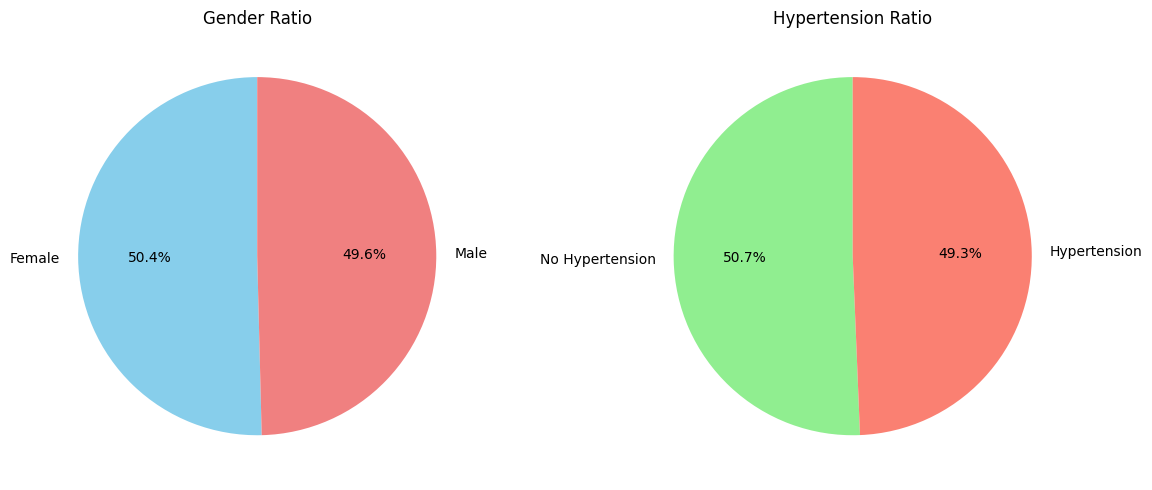

In [38]:
# 성별 비율 계산 (0: Female, 1: Male)
gender_counts = data['Sex'].value_counts()
# 고혈압 비율 계산 (0: No Hypertension, 1: Hypertension)
hypertension_counts = data['Blood_Pressure_Abnormality'].value_counts()

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# 남녀 비율 파이차트
axes[0].pie(
    gender_counts, 
    labels=['Female', 'Male'], 
    autopct='%1.1f%%', 
    startangle=90, 
    colors=['skyblue', 'lightcoral']
)
axes[0].set_title('Gender Ratio')

# 고혈압 비율 파이차트
axes[1].pie(
    hypertension_counts, 
    labels=['No Hypertension', 'Hypertension'], 
    autopct='%1.1f%%', 
    startangle=90, 
    colors=['lightgreen', 'salmon']
)
axes[1].set_title('Hypertension Ratio')

plt.tight_layout()
plt.show()




<Figure size 700x700 with 0 Axes>

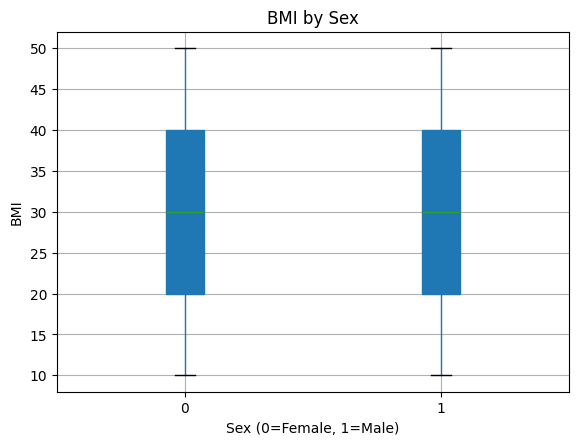

In [40]:
plt.figure(figsize=(7, 7))
data.boxplot(column='BMI', by='Sex', patch_artist=True)
plt.title('BMI by Sex')
plt.suptitle('')
plt.xlabel('Sex (0=Female, 1=Male)')
plt.ylabel('BMI')
plt.show()

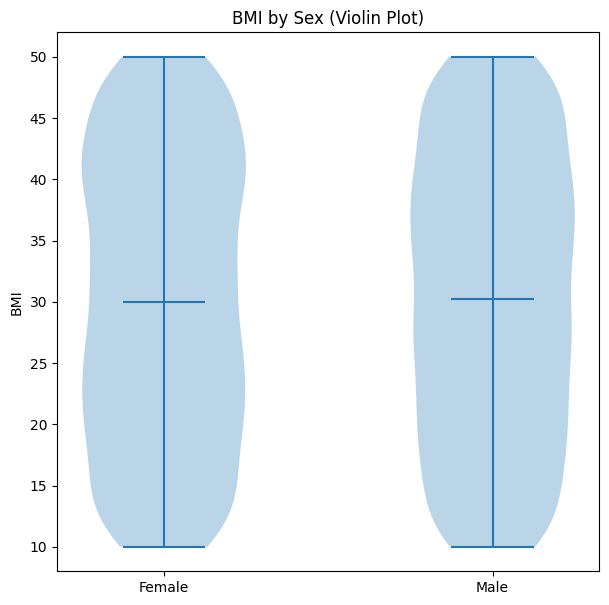

In [42]:
import pandas as pd
import matplotlib.pyplot as plt

data = pd.read_csv('BP_data.csv')

# 결측치 제거
data = data.dropna(subset=['BMI', 'Sex'])

# 그룹별 BMI 리스트 생성
bmi_female = data[data['Sex'] == 0]['BMI']
bmi_male = data[data['Sex'] == 1]['BMI']

plt.figure(figsize=(7, 7))
plt.violinplot([bmi_female, bmi_male], showmeans=True)
plt.xticks([1, 2], ['Female', 'Male'])
plt.title('BMI by Sex (Violin Plot)')
plt.ylabel('BMI')
plt.show()


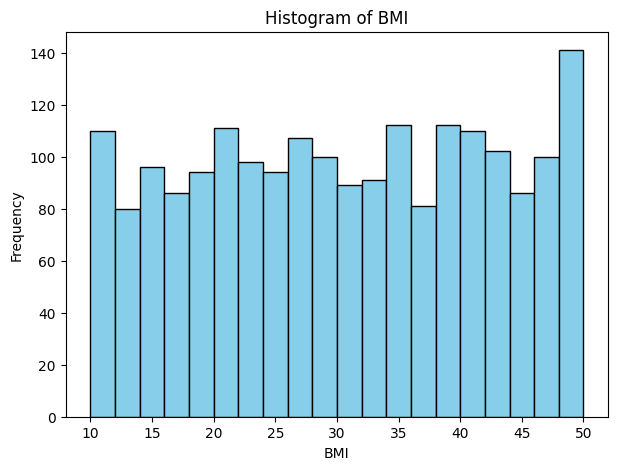

In [44]:
import pandas as pd
import matplotlib.pyplot as plt

# 데이터 로드
data = pd.read_csv('BP_data.csv')

# 결측치 제거 (필요시)
bmi = data['BMI'].dropna()

# 히스토그램 그리기
plt.figure(figsize=(7,5))
plt.hist(bmi, bins=20, color='skyblue', edgecolor='black')
plt.title('Histogram of BMI')
plt.xlabel('BMI')
plt.ylabel('Frequency')
plt.show()


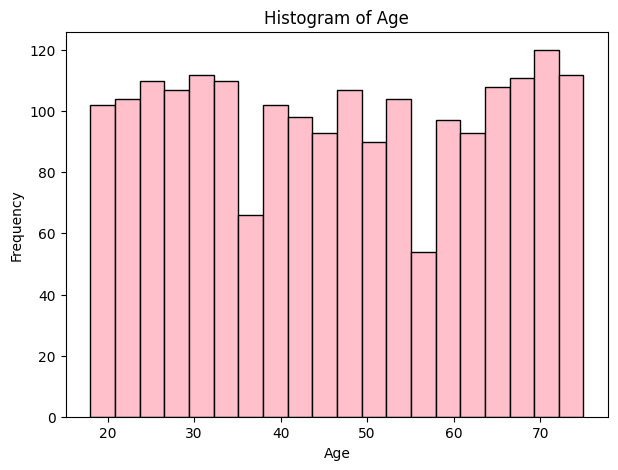

In [46]:
# 결측치 제거 (필요시)
bmi = data['Age'].dropna()

# 히스토그램 그리기
plt.figure(figsize=(7,5))
plt.hist(bmi, bins=20, color='pink', edgecolor='black')
plt.title('Histogram of Age')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()


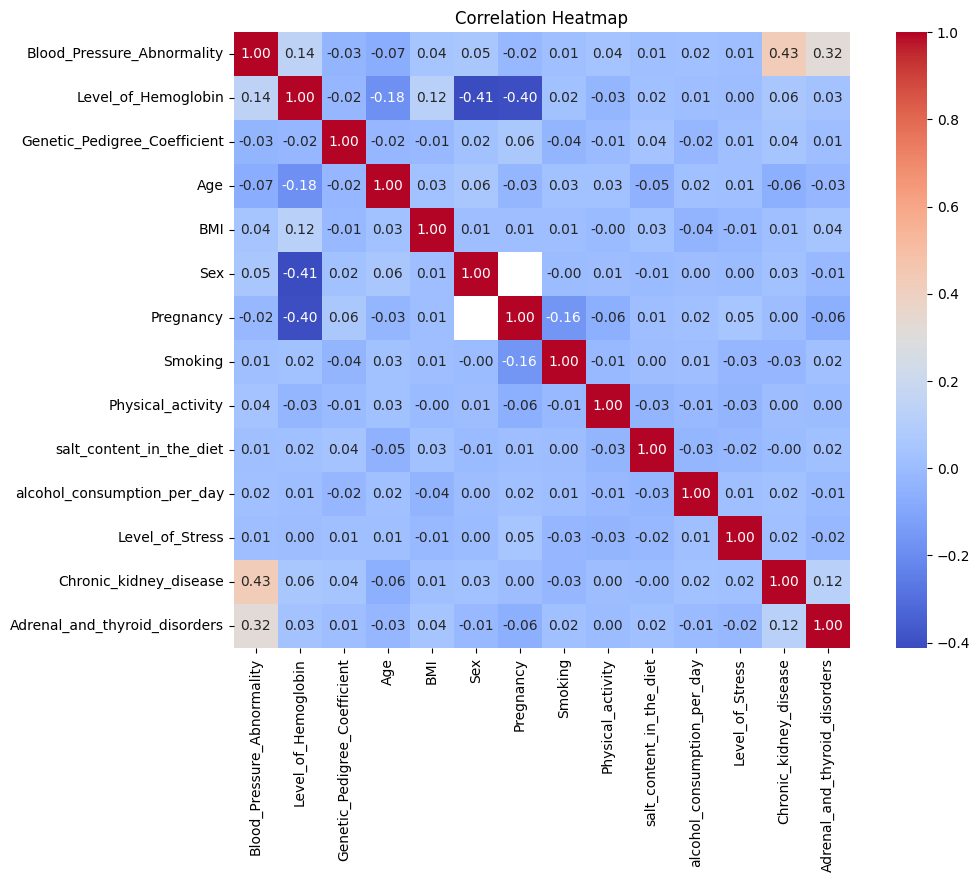

In [48]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 데이터 로드
data = pd.read_csv('BP_data.csv')

# 필요시 환자 번호 제거
if 'Patient_Number' in data.columns:
    data = data.drop('Patient_Number', axis=1)

# 수치형 컬럼만 선택
num_cols = data.select_dtypes(include='number')

# 상관계수 행렬 계산
corr = num_cols.corr()

# 히트맵 시각화
plt.figure(figsize=(12, 8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title('Correlation Heatmap')
plt.show()


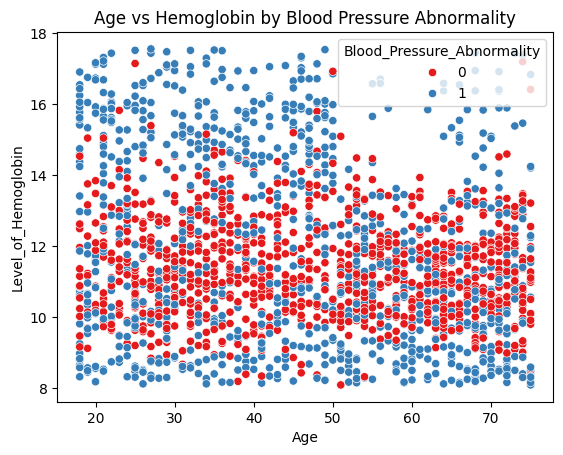

In [58]:
import seaborn as sns
import matplotlib.pyplot as plt

# 산점도: Age vs Level_of_Hemoglobin, 혈압 이상 여부로 색상 구분
sns.scatterplot(
    data=data,
    x='Age',
    y='Level_of_Hemoglobin',
    hue='Blood_Pressure_Abnormality',
    palette='Set1'
)
plt.title('Age vs Hemoglobin by Blood Pressure Abnormality')
plt.show()

/var/folders/3j/vdn2jmw56jl86z3vlf17czcw0000gn/T/ipykernel_10090/2458896656.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(


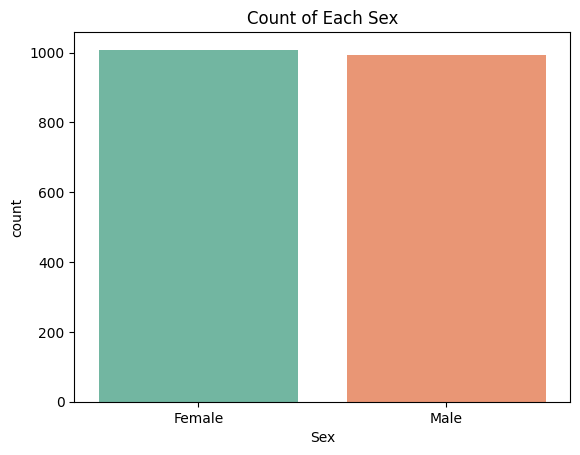

In [62]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(
    data=data,
    x='Sex',
    palette='Set2'
)
plt.xticks([0, 1], ['Female', 'Male'])
plt.title('Count of Each Sex')
plt.show()
